In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [4]:
# load the dataset
dataframe = read_csv('~/Documents/MyPrograming/R/TimeSeriesAnalysis/Projects/coal_production/coal_data.csv',header=0,squeeze=True)

In [5]:
import pandas as pd
# 日期格式转换函数
def convert_to_date(s):
    d = pd.to_datetime(s, format='%Y年%m月')
    return d

dataframe['Date'] = dataframe['Date'].apply(convert_to_date)
dataframe.index = dataframe['Date']
raw_dataframe = dataframe.copy()

# 2000-01 2009-01 2009-07
start_date = pd.to_datetime('2000-01')
end_date = pd.to_datetime('2009-12')
mask = (dataframe['Date'] > start_date) & (dataframe['Date'] <= end_date)
dataframe = dataframe.loc[mask]
dataframe = dataframe.iloc[::-1]['Num']

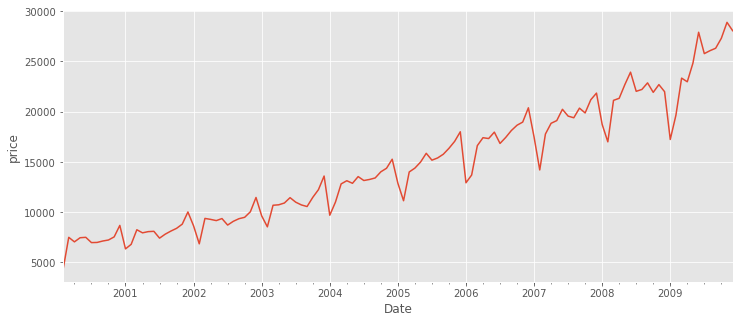

In [6]:
plt.figure(figsize=(12,5))
dataframe.plot()
plt.ylabel('price')
plt.show()

In [7]:
dataset = dataframe.values
dataset

array([  4298.2,   7496.1,   7044.1,   7454.9,   7496.2,   6970.2,
         6986.4,   7128.7,   7229.6,   7538. ,   8682.7,   6345.4,
         6797.4,   8249.4,   7942.2,   8062.6,   8093.8,   7414.2,
         7810. ,   8118.1,   8389.3,   8806.5,  10018.7,   8633.1,
         6848.7,   9378.2,   9281. ,   9160.9,   9362.5,   8716. ,
         9089.9,   9350.7,   9487.7,  10035. ,  11463.4,   9630.9,
         8538.6,  10687.4,  10732.9,  10911. ,  11443.9,  10993.3,
        10719.1,  10560.6,  11470.7,  12237.6,  13596.7,   9694.9,
        11001.6,  12812.8,  13129.3,  12872.3,  13540.9,  13150.4,
        13254.9,  13406. ,  14018. ,  14369.8,  15269.8,  12879.1,
        11138.3,  14002.3,  14386.6,  14989.1,  15859.6,  15175.6,
        15395.9,  15764.1,  16354.8,  17043.1,  18002.4,  12923. ,
        13697.3,  16621.8,  17411.8,  17328.5,  17966.7,  16842.1,
        17437.4,  18127.5,  18654.6,  18967.1,  20389.2,  17479. ,
        14203.2,  17775.9,  18846.6,  19115.3,  20239.7,  1956

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [39]:
# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [40]:
train.shape

(107,)

In [41]:
test.shape

(12,)

In [42]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [43]:
trainX

array([[ 0.        ],
       [ 0.1300176 ],
       [ 0.11164056],
       [ 0.12834253],
       [ 0.13002167],
       [ 0.10863599],
       [ 0.10929464],
       [ 0.11508016],
       [ 0.11918247],
       [ 0.13172114],
       [ 0.17826142],
       [ 0.08323338],
       [ 0.10161043],
       [ 0.16064466],
       [ 0.14815477],
       [ 0.1530499 ],
       [ 0.1543184 ],
       [ 0.12668778],
       [ 0.14277989],
       [ 0.15530637],
       [ 0.1663326 ],
       [ 0.18329478],
       [ 0.23257941],
       [ 0.17624482],
       [ 0.10369614],
       [ 0.20653849],
       [ 0.20258661],
       [ 0.19770368],
       [ 0.20590017],
       [ 0.1796153 ],
       [ 0.19481702],
       [ 0.20542042],
       [ 0.21099045],
       [ 0.23324213],
       [ 0.29131685],
       [ 0.21681256],
       [ 0.17240272],
       [ 0.25976687],
       [ 0.26161677],
       [ 0.26885782],
       [ 0.29052403],
       [ 0.2722039 ],
       [ 0.2610557 ],
       [ 0.25461154],
       [ 0.29161364],
       [ 0

In [44]:
trainY

array([ 0.1300176 ,  0.11164056,  0.12834253,  0.13002167,  0.10863599,
        0.10929464,  0.11508016,  0.11918247,  0.13172114,  0.17826142,
        0.08323338,  0.10161043,  0.16064466,  0.14815477,  0.1530499 ,
        0.1543184 ,  0.12668778,  0.14277989,  0.15530637,  0.1663326 ,
        0.18329478,  0.23257941,  0.17624482,  0.10369614,  0.20653849,
        0.20258661,  0.19770368,  0.20590017,  0.1796153 ,  0.19481702,
        0.20542042,  0.21099045,  0.23324213,  0.29131685,  0.21681256,
        0.17240272,  0.25976687,  0.26161677,  0.26885782,  0.29052403,
        0.2722039 ,  0.2610557 ,  0.25461154,  0.29161364,  0.32279364,
        0.37805081,  0.21941462,  0.27254136,  0.34617965,  0.35904765,
        0.34859875,  0.37578214,  0.35990551,  0.36415419,  0.37029749,
        0.39517968,  0.40948288,  0.44607435,  0.34887522,  0.2780992 ,
        0.39454137,  0.41016592,  0.43466187,  0.47005395,  0.44224444,
        0.45120122,  0.46617119,  0.49018739,  0.51817173,  0.55

In [45]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [46]:
trainX

array([[[ 0.        ]],

       [[ 0.1300176 ]],

       [[ 0.11164056]],

       [[ 0.12834253]],

       [[ 0.13002167]],

       [[ 0.10863599]],

       [[ 0.10929464]],

       [[ 0.11508016]],

       [[ 0.11918247]],

       [[ 0.13172114]],

       [[ 0.17826142]],

       [[ 0.08323338]],

       [[ 0.10161043]],

       [[ 0.16064466]],

       [[ 0.14815477]],

       [[ 0.1530499 ]],

       [[ 0.1543184 ]],

       [[ 0.12668778]],

       [[ 0.14277989]],

       [[ 0.15530637]],

       [[ 0.1663326 ]],

       [[ 0.18329478]],

       [[ 0.23257941]],

       [[ 0.17624482]],

       [[ 0.10369614]],

       [[ 0.20653849]],

       [[ 0.20258661]],

       [[ 0.19770368]],

       [[ 0.20590017]],

       [[ 0.1796153 ]],

       [[ 0.19481702]],

       [[ 0.20542042]],

       [[ 0.21099045]],

       [[ 0.23324213]],

       [[ 0.29131685]],

       [[ 0.21681256]],

       [[ 0.17240272]],

       [[ 0.25976687]],

       [[ 0.26161677]],

       [[ 0.26885782]],



In [47]:
# create and fit the LSTM network
model = Sequential()

model.add(LSTM(input_dim=1,output_dim=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start=time.time()
model.compile(loss='mean_squared_error',optimizer='Adam')
print ('compilation time:',time.time()-start)

history=model.fit(trainX,trainY,batch_size=1,nb_epoch=50,validation_split=0.1,verbose=2)

/home/shensir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/home/shensir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  after removing the cwd from sys.path.
/home/shensir/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # Remove the CWD from sys.path while we load stuff.
/home/shensir/anaconda3/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


compilation time: 0.03883695602416992
Train on 94 samples, validate on 11 samples
Epoch 1/50
2s - loss: 0.0548 - val_loss: 0.0697
Epoch 2/50
0s - loss: 0.0172 - val_loss: 0.0459
Epoch 3/50
0s - loss: 0.0092 - val_loss: 0.0235
Epoch 4/50
0s - loss: 0.0056 - val_loss: 0.0092
Epoch 5/50
0s - loss: 0.0042 - val_loss: 0.0100
Epoch 6/50
0s - loss: 0.0055 - val_loss: 0.0061
Epoch 7/50
0s - loss: 0.0039 - val_loss: 0.0067
Epoch 8/50
0s - loss: 0.0037 - val_loss: 0.0076
Epoch 9/50
0s - loss: 0.0033 - val_loss: 0.0073
Epoch 10/50
0s - loss: 0.0049 - val_loss: 0.0066
Epoch 11/50
0s - loss: 0.0051 - val_loss: 0.0061
Epoch 12/50
0s - loss: 0.0040 - val_loss: 0.0063
Epoch 13/50
0s - loss: 0.0039 - val_loss: 0.0064
Epoch 14/50
0s - loss: 0.0037 - val_loss: 0.0066
Epoch 15/50
0s - loss: 0.0051 - val_loss: 0.0072
Epoch 16/50
0s - loss: 0.0045 - val_loss: 0.0062
Epoch 17/50
0s - loss: 0.0042 - val_loss: 0.0063
Epoch 18/50
0s - loss: 0.0044 - val_loss: 0.0166
Epoch 19/50
0s - loss: 0.0046 - val_loss: 0.0

In [48]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [49]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [50]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1406.44 RMSE
Test Score: 1905.47 RMSE


In [51]:
# shift train predictions for plotting
trainPredictPlot=numpy.empty_like(dataset)
trainPredictPlot[:]=numpy.nan
trainPredictPlot=numpy.reshape(trainPredictPlot,(dataset.shape[0],1))
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [52]:
# shift test predictions for plotting
testPredictPlot=numpy.empty_like(dataset)
testPredictPlot[:]=numpy.nan
testPredictPlot=numpy.reshape(testPredictPlot,(dataset.shape[0],1))
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

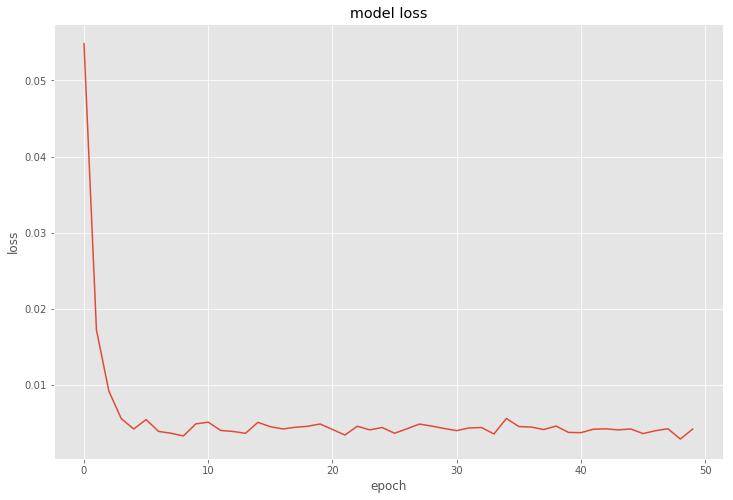

In [53]:
#summarize history for loss
fig=plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

/home/shensir/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


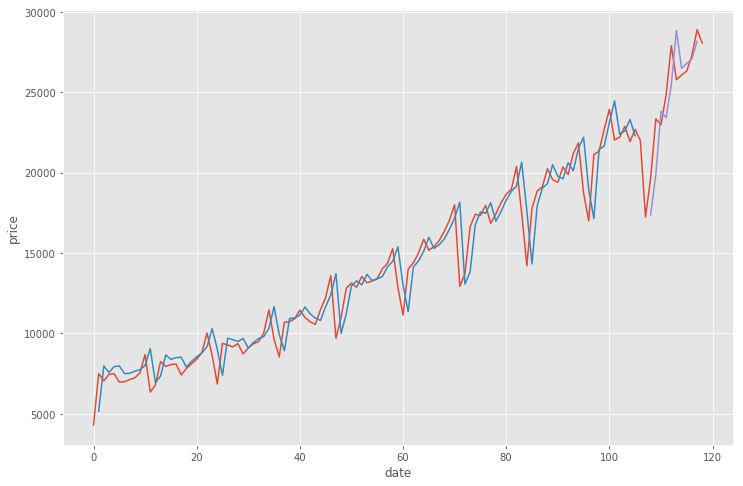

In [54]:
#plot predictions
fig=plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.ylabel('price')
plt.xlabel('date')
plt.show()

In [55]:
# 单独观察预测部分
Pred = testPredict[:,0]
Real = testY[0]

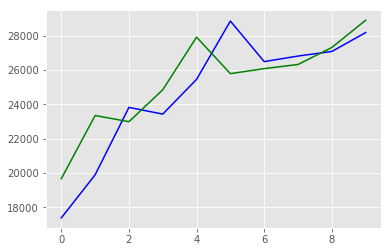

In [56]:
plt.plot(Pred, 'b')
plt.plot(Real, 'g')
plt.show()

In [57]:
# 对与后面六个月的预测
# 2009-02 20009-08
start_date = pd.to_datetime('2009-01')
end_date = pd.to_datetime('2009-07')
mask = (raw_dataframe['Date'] > start_date) & (raw_dataframe['Date'] <= end_date)
data_test = raw_dataframe.loc[mask]
data_test = data_test.iloc[::-1]['Num']
test_true = data_test.values
test_true

array([ 19656.5,  23342.7,  22980. ,  24841.1,  27908.5,  25781.8])

In [58]:
import numpy as np
# 此处testY[0][0:6]即为test_true,已经在测试集合
test_pred = [float(testPredict[0:6][i]) for i in range(6)]
test_pred

[17373.197265625,
 19883.384765625,
 23815.80859375,
 23423.349609375,
 25448.943359375,
 28846.12890625]

In [59]:
RMSE_test = math.sqrt(np.mean((np.array(test_true)-test_pred)**2))
RMSE_test

2426.5358008626504